In [1]:
import os
import tensorflow as tf
import cv2
import tensorflow.keras
from keras.layers import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.models import Model

#Data set

In [2]:
(train_im,y_train),(test_im,y_test)=tensorflow.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
train_im.shape

(50000, 32, 32, 3)

In [4]:
y_train=y_train.reshape(-1,)

In [5]:
train_im=train_im/225

#activation function

In [6]:
def custom_activation(x):
  result = tf.where(x >= 0, x, 0.06965312312312*x)
  return result

#model

In [7]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(custom_activation)(x)

  return x

In [8]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=regularizers.l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(custom_activation)(x)

  return x

In [9]:
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(custom_activation)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(10, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [10]:
model = resnet50()

In [11]:
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [12]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [13]:
hitory=model.fit(train_im,y_train,epochs=160,batch_size=64)

Epoch 1/160
782/782 [==============================] - 89s 50ms/step - loss: 13.5548 - accuracy: 0.3929
Epoch 2/160
782/782 [==============================] - 38s 48ms/step - loss: 6.3355 - accuracy: 0.4400
Epoch 3/160
782/782 [==============================] - 38s 48ms/step - loss: 4.6972 - accuracy: 0.3638
Epoch 4/160
782/782 [==============================] - 37s 48ms/step - loss: 3.7453 - accuracy: 0.3790
Epoch 5/160
782/782 [==============================] - 38s 48ms/step - loss: 3.0308 - accuracy: 0.4458
Epoch 6/160
782/782 [==============================] - 37s 48ms/step - loss: 3.4017 - accuracy: 0.4210
Epoch 7/160
782/782 [==============================] - 38s 48ms/step - loss: 2.8776 - accuracy: 0.4495
Epoch 8/160
782/782 [==============================] - 37s 48ms/step - loss: 3.1975 - accuracy: 0.4533
Epoch 9/160
782/782 [==============================] - 37s 48ms/step - loss: 3.1136 - accuracy: 0.4261
Epoch 10/160
782/782 [==============================] - 39s 49ms/step - 

In [14]:
y_prob=model.predict(test_im)
y_pred=y_prob.argmax(axis=1)

313/313 [==============================] - 5s 12ms/step


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.1715

Text(0, 0.5, 'Loss')

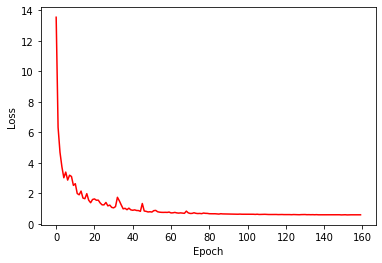

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.plot(hitory.history['loss'],'r')
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

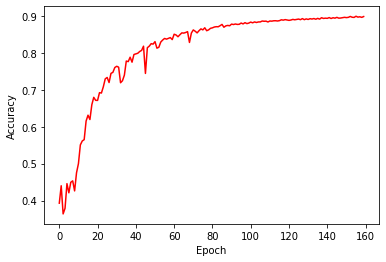

In [17]:
plt.plot(hitory.history['accuracy'],'r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

[Text(33.0, 0.5, 'Predicted values'), Text(0.5, 15.0, 'True values')]

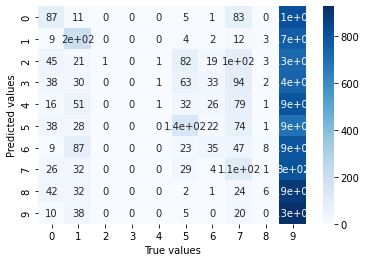

In [ ]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
ax=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set(xlabel="True values", ylabel="Predicted values")